In [1]:
from fastai.vision.all import *
from fastai import *
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from pathlib import Path
import imageio

# 1.0 Basic Setup (no augmentation)

### 1.1 Prepare data

In [8]:
tile_size = 256

In [9]:
train_path = Path('/home/minas/slumworld/data/input/train_set')

train_path.ls()

(#8) [Path('/home/minas/slumworld/data/input/train_set/labels'),Path('/home/minas/slumworld/data/input/train_set/models'),Path('/home/minas/slumworld/data/input/train_set/images_128'),Path('/home/minas/slumworld/data/input/train_set/labels_128'),Path('/home/minas/slumworld/data/input/train_set/codes.txt'),Path('/home/minas/slumworld/data/input/train_set/masks_128'),Path('/home/minas/slumworld/data/input/train_set/images'),Path('/home/minas/slumworld/data/input/train_set/masks')]

## Sampling from the training set

In [10]:
def show_image_i(images, labels, i=None, predictions=None):
    if i is None:
        i = np.random.randint(low=0, high=len(labels))
    print("Image ",i)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(221)
    plt.imshow(images[i], axes=ax)
    plt.title(f"Image {i}")
    ax = fig.add_subplot(222)
    plt.imshow(labels[i], axes=ax)
    plt.title(f"Label {i}")
    if predictions is not None:
        ax = fig.add_subplot(224)
        plt.imshow(predictions[i], axes=ax)
        plt.title(f"Prediction {i}")

In [11]:
def load_images_labels(datapath, tile_size=128):
    label_files = sorted([str(f.absolute()) for f in (datapath/'labels').iterdir()])
    image_files = sorted([str(f.absolute()) for f in (datapath/'images').iterdir()])
    labels = np.zeros([len(label_files),tile_size,tile_size],dtype=np.uint8)
    images = np.zeros([len(label_files),tile_size,tile_size,3],dtype=np.uint8)
    for i, dpoint_i in enumerate(zip(label_files, image_files)):
        labels[i] = imageio.imread(dpoint_i[0])
        images[i] = imageio.imread(dpoint_i[1])
    return labels, images

In [12]:
train_labels, train_images = load_images_labels(train_path, tile_size=tile_size)

Image  623


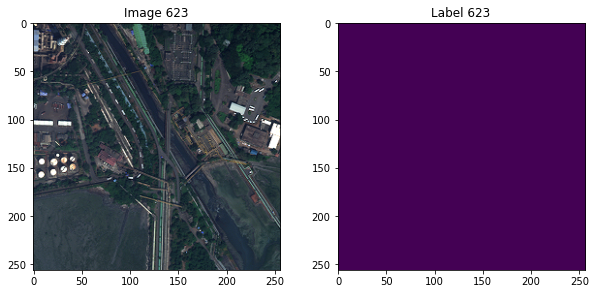

In [16]:
show_image_i(images=train_images, labels=train_labels,\
            i=None, predictions=None)

### 1.2 Create data loader

In [17]:
model_1_path = Path('/home/minas/slumworld/dev/fastai/model')/'first_model'

In [18]:
dls = SegmentationDataLoaders.from_label_func(
    train_path, bs=20, fnames = get_image_files(train_path/"images"),
    label_func = lambda o: train_path/'labels'/f'{o.stem}{o.suffix}',
    codes = np.loadtxt(train_path/'codes.txt', dtype=str)
)

### 1.3 Create model (resnet16/resnet34)

In [19]:
learn = unet_learner(dls, resnet34)

#### Inspect model

In [37]:
learn.summary()

DynamicUnet (Input shape: ['20 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               20 x 64 x 128 x 128  9,408      False     
________________________________________________________________
BatchNorm2d          20 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 20 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            20 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               20 x 64 x 64 x 64    36,864     False     
________________________________________________________________
BatchNorm2d          20 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 20 x 64 x 64 x 64    0          False     
________________________________________________

### 1.4 Select learning rate

In [ ]:
learn.lr_find()

### 1.5 Train (fine tune) model

In [ ]:
learn.fine_tune(5, 1e-4)

### 1.6 Save trained model

In [ ]:
learn.save(file=model_1_path)

### 1.6 Load saved model

In [20]:
learn.load(file=model_1_path)

### 1.7 Predict for the test set


In [29]:
test_path = Path('/home/minas/slumworld/data/input/test_set')

In [43]:
files = sorted([str(f.absolute()) for f in (test_path/'images').iterdir()])

images = np.zeros([len(files),tile_size,tile_size,3],dtype=np.uint8)

In [44]:
label_files = sorted([str(f.absolute()) for f in (test_path/'labels').iterdir()])
labels = np.zeros([len(label_files),tile_size, tile_size],dtype=np.uint8)
predictions = np.zeros([len(label_files),tile_size, tile_size],dtype=np.uint8)
for i, label_i in enumerate(label_files):
    labels[i] = imageio.imread(label_i)

In [45]:
for i, file_i in enumerate(files):
    images[i] = imageio.imread(file_i)
    predictions[i] = learn.predict(images[i])[1].numpy()

Image  78


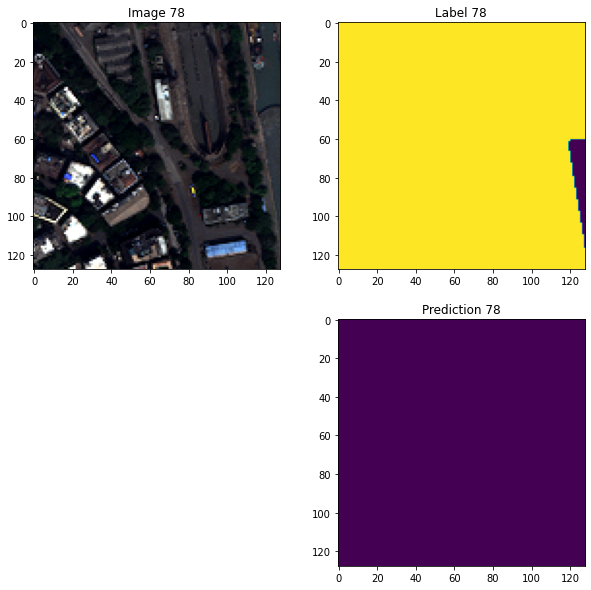

In [53]:
show_image_i(images=images, labels=labels, \
             predictions=predictions)

# 2.0 Using the datablock to add data augmentation

In [61]:
tile_size = 256

In [21]:
codes = ['not_slums','slum']
slums = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = lambda o: train_path/'labels'/f'{o.stem}{o.suffix}',
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(tile_size, tile_size)))

In [22]:
dls = slums.dataloaders(train_path/"images", path=train_path, bs=10)

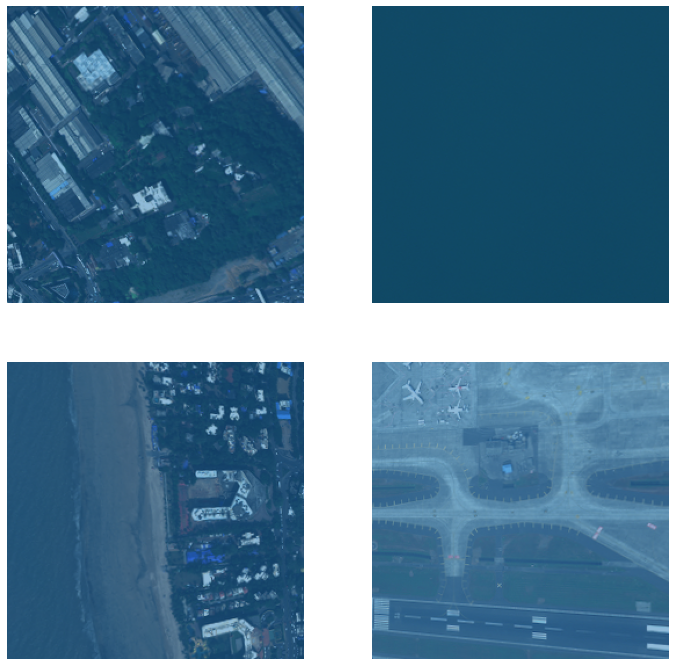

In [23]:
dls.show_batch(max_n=4, figsize=(12, 12))

In [24]:
learn = unet_learner(dls, resnet18)

In [58]:
learn.summary()

DynamicUnet (Input shape: ['10 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               10 x 64 x 128 x 128  9,408      False     
________________________________________________________________
BatchNorm2d          10 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 10 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            10 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               10 x 64 x 64 x 64    36,864     False     
________________________________________________________________
BatchNorm2d          10 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 10 x 64 x 64 x 64    0          False     
________________________________________________

In [ ]:
learn.lr_find()

In [11]:
learn.fine_tune(5, 7e-5)

epoch,train_loss,valid_loss,time
0,0.133258,0.104818,02:27


epoch,train_loss,valid_loss,time
0,0.099254,0.091981,02:38
1,0.089657,0.085122,02:40
2,0.084795,0.085810,02:40
3,0.082145,0.082470,02:41
4,0.082357,0.081817,02:41


In [26]:
model_2_path = Path('/home/minas/slumworld/dev/fastai/model')/'res18_aug_model'

In [12]:
learn.save(file=model_2_path)

Path('/home/minas/slumworld/dev/fastai/model/res18_aug_model.pth')

In [27]:
learn.load(file=model_2_path)

### 1.7 Predict for the test set


In [32]:
tile_size

256

In [30]:
files = sorted([str(f.absolute()) for f in (test_path/'images').iterdir()])

images = np.zeros([len(files),tile_size, tile_size,3],dtype=np.uint8)

In [34]:
label_files = sorted([str(f.absolute()) for f in (test_path/'labels').iterdir()])
labels = np.zeros([len(label_files),tile_size, tile_size], dtype=np.uint8)
predictions2 = np.zeros([len(label_files), tile_size, tile_size], dtype=np.uint8)
for i, label_i in enumerate(label_files):
    labels[i] = imageio.imread(label_i)

ValueError: could not broadcast input array from shape (128,128) into shape (256,256)

In [45]:
for i, file_i in enumerate(files):
    images[i] = imageio.imread(file_i)
    predictions2[i] = learn.predict(images[i])[1].numpy()

In [ ]:
show_image_i(images=images, labels=labels, \
             predictions=predictions2)